录入数据库

In [1]:
import sqlite3
import pandas as pd

# 连接到 SQLite 数据库
db_path = "../anime_data.db"  # 替换为你的 SQLite 数据库文件路径
conn = sqlite3.connect(db_path)
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置全局字体为 SimHei
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

In [2]:
# 查询数据库中的所有表名
def get_table_names(conn):
    query = "SELECT name FROM sqlite_master WHERE type='table';"
    tables = pd.read_sql(query, conn)
    return tables['name'].tolist()

table_names = get_table_names(conn)
print("Tables in database:", table_names)


Tables in database: ['Anime', 'Category', 'sqlite_sequence', 'Anime_Category', 'Production', 'Anime_Production', 'Comments']


In [3]:
table_names = [table for table in table_names if table != 'sqlite_sequence']
def load_tables_to_pandas(conn):
    tables = {}
    for table_name in table_names:
        query = f"SELECT * FROM {table_name};"
        tables[table_name] = pd.read_sql(query, conn)
    return tables

dataframes = load_tables_to_pandas(conn)

In [4]:
for table_name, df in dataframes.items():
    globals()[f"{table_name.lower()}_df"] = df

检查缺失值

In [5]:
# 查找每个表的缺失值
def find_missing_values(dataframes):
    missing_values = {}
    for table, df in dataframes.items():
        missing_values[table] = df.isnull().sum()
    return missing_values

missing_values = find_missing_values(dataframes)
for table, missing in missing_values.items():
    print(f"Missing values in table {table}:\n{missing}\n")

Missing values in table Anime:
anime_id        0
anime_title     0
score           0
score_count     0
release_date    0
dtype: int64

Missing values in table Category:
category_id      0
category_name    0
dtype: int64

Missing values in table Anime_Category:
anime_id       0
category_id    0
dtype: int64

Missing values in table Production:
production_id      0
production_name    0
dtype: int64

Missing values in table Anime_Production:
anime_id         0
production_id    0
dtype: int64

Missing values in table Comments:
comment_id    0
anime_id      0
comment       0
time_ago      0
dtype: int64



数据类型转换

In [6]:
# 数据类型转换

# 转换 'score' 和 'score_count' 为数值类型
anime_df['score'] = pd.to_numeric(anime_df['score'], errors='coerce')
anime_df['score_count'] = pd.to_numeric(anime_df['score_count'], errors='coerce')

category_df['category_name'] = category_df['category_name'].astype('category')

# 查看数据类型
#print(anime_df.dtypes)
print(category_df.dtypes)   


category_id         int64
category_name    category
dtype: object


缺失值处理，使用人工智能技术填补缺失值？或直接删除！

分箱

In [7]:
# 对评分进行分箱
bins = [0, 5, 7, 8, 9, 10]  # 分为四个区间
labels = ['差', '一般', '好', '优秀', '神作']  # 给每个区间赋予标签
anime_df['score_category'] = pd.cut(anime_df['score'], bins=bins, labels=labels, include_lowest=True)

# 查看分箱后的数据
print(anime_df[['score', 'score_category']].head())

   score score_category
0    6.2             一般
1    7.8              好
2    7.3              好
3    7.2              好
4    5.5             一般


分组聚合

In [8]:
# 按评分区间进行分组，计算每个区间的平均评分和评分人数
grouped = anime_df.groupby('score_category', observed=False).agg(
    avg_score=('score', 'mean'),
    avg_score_count=('score_count', 'mean'),
    total_animes=('anime_id', 'count')
).reset_index()

grouped

,score_category,avg_score,avg_score_count,total_animes
0,差,4.374638,392.775362,138
1,一般,6.023171,960.176829,492
2,好,7.453333,3007.380952,105
3,优秀,8.255556,6795.222222,9
4,神作,NaN,NaN,0


In [9]:
# 删除包含缺失值的行
anime_df_cleaned = anime_df.dropna()

# 查看删除缺失值后的数据
print(anime_df_cleaned.head())
anime_df_cleaned.isnull().sum()
anime_df = anime_df_cleaned

   anime_id    anime_title  score  score_count release_date score_category
0    151101             深海    6.2         1434   2023-01-22             一般
1    208827  少女与战车 最终章 第4话    7.8         1150   2023-10-06              好
2    217021             冥王    7.3         2994   2023-10-26              好
3    228715      你想活出怎样的人生    7.2         4917   2023-07-14              好
4    235634           机械手臂    5.5          520   2024-10-03             一般


In [10]:
# 将 release_date 列转换为 datetime 类型
anime_df['release_date'] = pd.to_datetime(anime_df['release_date'], errors='coerce')

# 提取季度信息
anime_df['release_quarter'] = anime_df['release_date'].dt.to_period('Q')

# 查看按季度分类后的数据
print(anime_df[['anime_title', 'release_date', 'release_quarter']].head())

     anime_title release_date release_quarter
0             深海   2023-01-22          2023Q1
1  少女与战车 最终章 第4话   2023-10-06          2023Q4
2             冥王   2023-10-26          2023Q4
3      你想活出怎样的人生   2023-07-14          2023Q3
4           机械手臂   2024-10-03          2024Q4


聚类

c:\Users\15098\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 系统找不到指定的文件。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\15098\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\15098\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\15098\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\15098\AppData\L

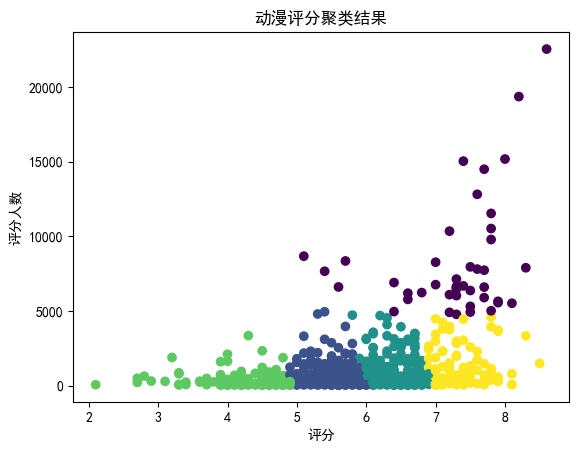

In [11]:
# 导入必要的库
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 特征选择
features = anime_df[['score', 'score_count']]

# 数据标准化
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# K-Means 聚类
kmeans = KMeans(n_clusters=5, random_state=42)

# 使用 .loc 进行赋值以避免 SettingWithCopyWarning
anime_df.loc[:, 'cluster'] = kmeans.fit_predict(features_scaled)

# 可视化聚类结果
plt.scatter(anime_df['score'], anime_df['score_count'], c=anime_df['cluster'], cmap='viridis')
plt.xlabel('评分')
plt.ylabel('评分人数')
plt.title('动漫评分聚类结果')
plt.show()

In [12]:
# 1. 连接 anime_category_df 和 category_df，获取类别名称
merged_df = pd.merge(anime_category_df, category_df, on='category_id', how='left')

# 2. 按 category_name 分组，统计每个类别的动漫数量
category_count = merged_df.groupby('category_name').size().reset_index(name='anime_count')

# 重命名列
category_count.columns = ['category_name', 'anime_count']

C:\Users\15098\AppData\Local\Temp\ipykernel_169044\3172450246.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_count = merged_df.groupby('category_name').size().reset_index(name='anime_count')


分析

评分和评分人数正态分布分析

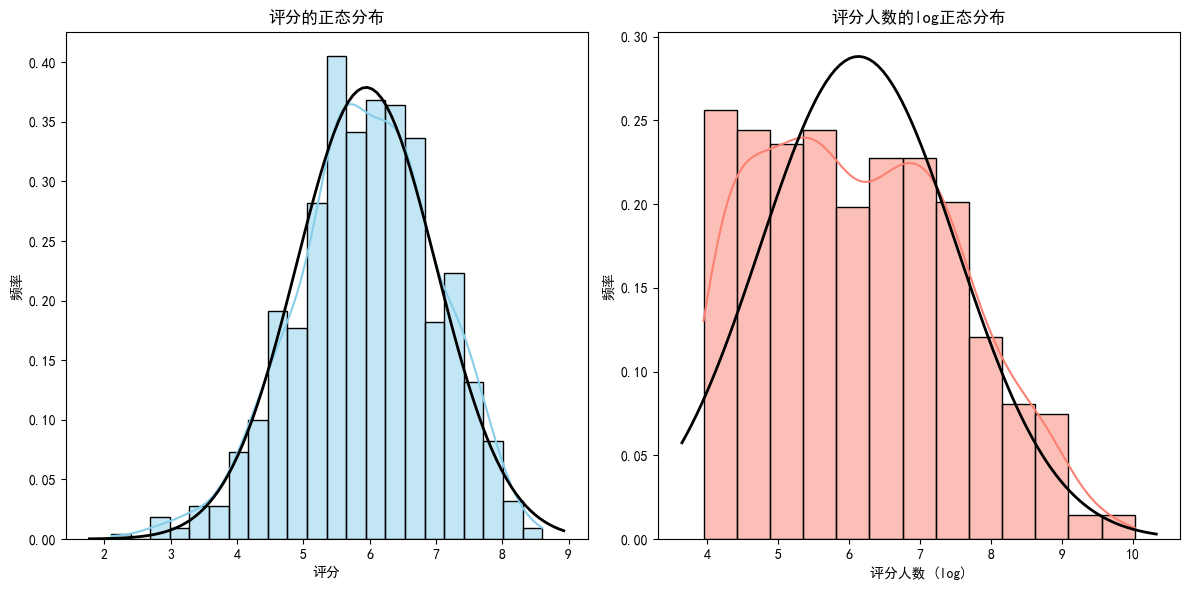

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np

# 绘制评分的正态分布图
plt.figure(figsize=(12, 6))

# 使用displot绘制评分的分布
plt.subplot(1, 2, 1)
sns.histplot(anime_df['score'], kde=True, stat='density', color='skyblue')

# Fit a normal distribution and plot it
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, anime_df['score'].mean(), anime_df['score'].std())
plt.plot(x, p, 'k', linewidth=2)
plt.title('评分的正态分布')
plt.xlabel('评分')
plt.ylabel('频率')

# 对评分人数取log
y = np.log(anime_df['score_count'] + 1)  # Adding 1 to avoid log(0)

# 使用displot绘制评分人数的log分布
plt.subplot(1, 2, 2)
sns.histplot(y, kde=True, stat='density', color='salmon')

# Fit a normal distribution to the log-transformed data and plot it
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, y.mean(), y.std())
plt.plot(x, p, 'k', linewidth=2)
plt.title('评分人数的log正态分布')
plt.xlabel('评分人数 (log)')
plt.ylabel('频率')

plt.tight_layout()
plt.show()


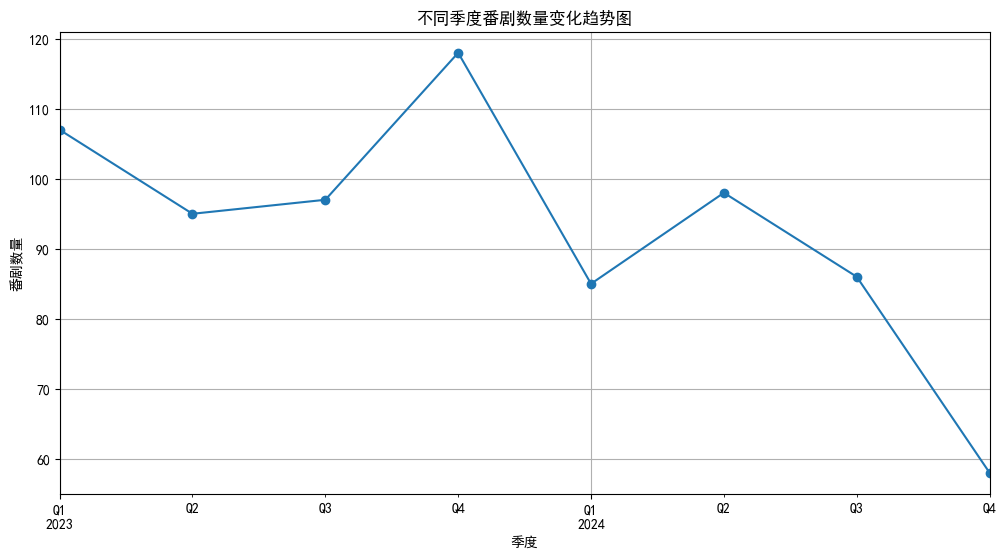

In [14]:
# 按季度分组，计算每个季度的番剧数量
quarterly_counts = anime_df['release_quarter'].value_counts().sort_index()

# 绘制趋势图
plt.figure(figsize=(12, 6))
quarterly_counts.plot(kind='line', marker='o')
plt.title('不同季度番剧数量变化趋势图')
plt.xlabel('季度')
plt.ylabel('番剧数量')
plt.grid(True)
plt.show()

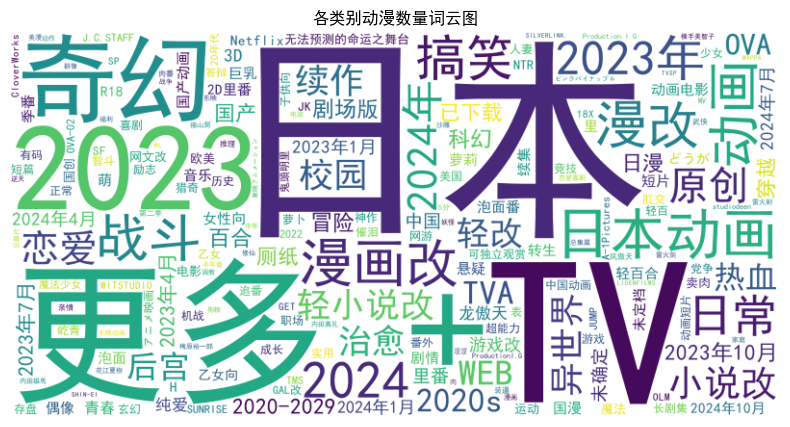

In [15]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 将类别名称和动漫数量组合成字典，作为词云的基础
word_freq = dict(zip(category_count['category_name'], category_count['anime_count']))

# 生成词云图
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path='simhei.ttf').generate_from_frequencies(word_freq)

# 绘制词云图
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('各类别动漫数量词云图')
plt.show()


C:\Users\15098\AppData\Local\Temp\ipykernel_169044\1831703412.py:65: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'wordclouds/wordcloud_{quarter}.png'))


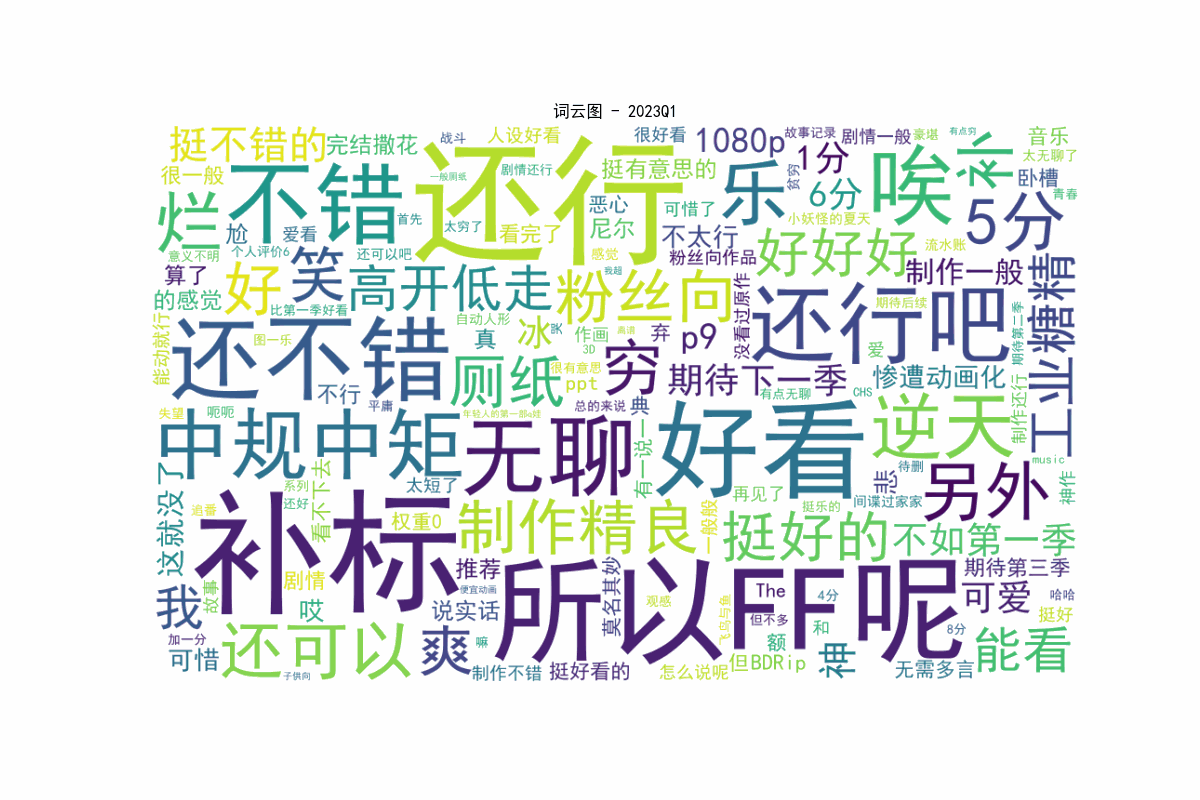

In [17]:
import pandas as pd
import re
from wordcloud import WordCloud
import imageio
import os
import matplotlib.pyplot as plt
from IPython.display import Image

# 创建保存词云图的文件夹
if not os.path.exists('wordclouds'):
    os.makedirs('wordclouds')

# 停用词列表（包含无用的词，如“ep”，“集”，“话”等）
stopwords = set([
    'ep', '集', '话', '番剧', '评分', '观看', '评论', '内容', '做的', '的', '本', '就是', '这个', '一个', '还是', '怎么', '虽然', 
    '这么', '会', '很', '也', '而', '哦', '嗯', 'jpg', 'png', 'gif', 'bgm', 'season', 'op', 'ed', 'bgm38', '已经', '而且', 
    '越来越', '反正', '真是', '甚至', '自己', '然后', '那种', '不是', '啊', '什么', '并且', '不过', '可能', '其实', '都', 
    '说', '有', '多', '非常', '不', '也有', '人', '从', '一开始', '到', '有时候', '些', '时间', '一起', '那', '做', 
    '一会儿', '并不', '这种', '去', '这样', '一般', '是不是', '以前', '多少', '别', '但是', '呢', '想', '希望', '能', 
    '还会', '给我', '掉', '长', '留', '所以', '咱们', '会觉得', '如果', '或', '从而', '突然', '您', '他人', '那样', 
    '这里', '那里', '那个', 'p', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'q', 'ps', 'b38', 'of',
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'Q', 'PS', 'B38', 'OF', 'S', 'https', 'com', 'www'
])


# 按季度生成词云图
for quarter, group in anime_df.groupby('release_quarter'):
    # 合并该季度的所有评论文本
    quarter_comments = ' '.join(comments_df[comments_df['anime_id'].isin(group['anime_id'])]['comment'].tolist())
    
    # 对评论文本进行预处理
    quarter_comments = ' '.join([word for word in quarter_comments.split() if word not in stopwords])  # 去掉停用词
    
    quarter_comments = ''.join(re.sub(r'ep\d+', '', quarter_comments))  # 去掉类似“ep12”的词语
    
    quarter_comments = ''.join(re.sub(r'Ep\d+', '', quarter_comments))  # 去掉类似“ep12”的词语
    quarter_comments = ''.join(re.sub(r'EP\d+', '', quarter_comments))  # 去掉类似“ep12”的词语

    # 生成词云图，调整最大和最小字体大小以便更好地填充画布
    wordcloud = WordCloud(
        width=1000,  # 调整为更大的宽度
        height=600,  # 调整为更大的高度
        background_color='white',
        font_path='simhei.ttf',  # 使用中文字体（如果需要的话）
        max_words=200,  # 控制最大显示的单词数
        min_font_size=10,  # 设置最小字体大小
        max_font_size=150,  # 设置最大字体大小
        collocations=False,  # 防止生成词语搭配（适用于中文等语言）
        stopwords=stopwords  # 传入停用词列表
    ).generate(quarter_comments)
    
    # 绘制词云图并添加季度显示
    plt.figure(figsize=(12, 8))  # 设置更大的画布
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'词云图 - {quarter}')
    
    # 保存词云图
    plt.savefig(f'wordclouds/wordcloud_{quarter}.png')
    plt.close()

# 生成动态词云图（GIF）
images = []
for quarter in anime_df['release_quarter'].unique():
    images.append(imageio.imread(f'wordclouds/wordcloud_{quarter}.png'))

# 调整间隔时间，将动画时间设为2秒
imageio.mimsave('wordclouds/wordclouds_dynamic.gif', images, duration=100)  # 设置较长的间隔时间

# 显示动态词云图
Image(filename='wordclouds/wordclouds_dynamic.gif')


In [ ]:
conn.close()